### Import Required Libraries

In [1]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix, hstack, vstack, find as sparse_find, issparse
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
import os

In [2]:
# This is just to suppress some warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

### Global constants

In [3]:
K_EVAL = 5 # We are only testing upto precision@5 same as in paper

### Dataloader for BibTex

In [ ]:
class DataLoader:
    """Handles loading multilabel data and train/test splits."""

    def load_multilabel_data(self, filepath):
        """
        Loads data from a LIBSVM multilabel format file.
        Args:
            filepath (str): Path to the data file.
        Returns:
            tuple: (X, Y) where X is the feature matrix (csr_matrix n_samples x n_features)
                and Y is the label matrix (csr_matrix n_samples x n_labels), or (None, None) if error.
        """
        if not os.path.exists(filepath):
            print(f"Error: Data file not found at {filepath}")
            return None, None

        try:
            with open(filepath, 'r') as f:
                first_line = f.readline().split()
                if len(first_line) < 3:
                    raise ValueError("Invalid header format in data file.")
                n_samples = int(first_line[0])
                n_features = int(first_line[1])
                n_labels = int(first_line[2])

                if n_samples <= 0 or n_features <= 0 or n_labels <= 0:
                    raise ValueError("Invalid dimensions in header.")

                X_lil = lil_matrix((n_samples, n_features), dtype=np.float64)
                Y_lil = lil_matrix((n_samples, n_labels), dtype=np.int8)

                for i, line in enumerate(f):
                    if i >= n_samples:
                        print(f"Warning: More lines than expected ({n_samples}) in data file. Stopping.")
                        break

                    parts = line.strip().split(' ', 1)
                    labels_str = parts[0]
                    features_str = parts[1] if len(parts) > 1 else ''

                    if labels_str:
                        try:
                            label_indices = [int(l) for l in labels_str.split(',')]
                            for label_idx in label_indices:
                                if 0 <= label_idx < n_labels:
                                    Y_lil[i, label_idx] = 1
                                else:
                                    print(f"Warning: Label index {label_idx} out of bounds [0, {n_labels-1}) in line {i+2}. Skipping.")
                        except ValueError:
                            print(f"Warning: Skipping incorrect label string '{labels_str}' in line {i+2}")

                    if features_str:
                        for feature_pair in features_str.split(' '):
                            try:
                                idx_str, val_str = feature_pair.split(':')
                                feature_idx = int(idx_str)
                                feature_val = float(val_str)
                                if 0 <= feature_idx < n_features:
                                    X_lil[i, feature_idx] = feature_val
                                else:
                                    print(f"Warning: Feature index {feature_idx} out of bounds [0, {n_features-1}) in line {i+2}. Skipping.")
                            except ValueError:
                                print(f"Warning: Skipping incorrect feature pair '{feature_pair}' in line {i+2}")
                                continue

            X_csr = X_lil.tocsr()
            Y_csr = Y_lil.tocsr()
            print(f"Loaded data: X shape {X_csr.shape}, Y shape {Y_csr.shape}")
            print(f"X sparsity: {X_csr.nnz / (X_csr.shape[0] * X_csr.shape[1]):.4f}")
            print(f"Y sparsity: {Y_csr.nnz / (Y_csr.shape[0] * Y_csr.shape[1]):.4f}")
            return X_csr, Y_csr

        except Exception as e:
            print(f"Error loading data from {filepath}: {e}")
            return None, None

    def load_split_indices(self, filepath):
        """
        Loads 1-based train and test split indices from a file and converts to 0-based.
        Args:
            filepath (str): Path to the split file.
        Returns:
            np.ndarray: Array of 0-based indices or None if any error is founded.
        """
        if not os.path.exists(filepath):
            print(f"Error: Split file not found at {filepath}")
            return None

        indices = []
        try:
            with open(filepath, 'r') as f:
                for line_num, line in enumerate(f):
                    try:
                        indices.extend([int(x) - 1 for x in line.strip().split()])
                    except ValueError:
                        print(f"Warning: Skipping non-integer value in split file {filepath}, line {line_num+1}")
            return np.array(indices)
        except Exception as e:
            print(f"Error loading split indices from {filepath}: {e}")
            return None

    def get_train_test_split(self, data_filepath, train_split_filepath, test_split_filepath):
        """Loads data and splits it into train/test sets."""
        print(f"\nLoading full dataset from {data_filepath}...")
        X, Y = self.load_multilabel_data(data_filepath)
        if X is None or Y is None:
            return None, None, None, None

        print(f"Loading train split from {train_split_filepath}...")
        train_indices = self.load_split_indices(train_split_filepath)
        if train_indices is None:
            return None, None, None, None

        print(f"Loading test split from {test_split_filepath}...")
        test_indices = self.load_split_indices(test_split_filepath)
        if test_indices is None:
            return None, None, None, None

        n_samples = X.shape[0]
        if np.any(train_indices < 0) or np.any(train_indices >= n_samples):
            print("Error: Invalid train indices found.")
            return None, None, None, None
        if np.any(test_indices < 0) or np.any(test_indices >= n_samples):
            print("Error: Invalid test indices found.")
            return None, None, None, None

        print("\nSplitting data...")
        X_train, Y_train = X[train_indices], Y[train_indices]
        X_test, Y_test = X[test_indices], Y[test_indices]
        print(f"Train shapes: X={X_train.shape}, Y={Y_train.shape}")
        print(f"Test shapes:  X={X_test.shape}, Y={Y_test.shape}")

        return X_train, Y_train, X_test, Y_test

### Models

### ConstantPredictor used when the number of classes in a group is same

In [5]:
class ConstantPredictor:
    """A simple predictor for cases where all labels in a group are constant."""
    def __init__(self, value):
        if value not in [0, 1]:
             raise ValueError("Constant value must be 0 or 1")
        self.value = int(value)

    def predict(self, X):
        return np.full(X.shape[0], self.value, dtype=np.int8)

    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, 2), dtype=float)
        proba[:, self.value] = 1.0
        return proba

    def fit(self, X, y):
        pass

### NMFGT class, which will train the NMFGT model by creating the GT matrix and training many intermediate classifiers.

In [ ]:
class NMFGTModel:
    """
    Implements the Multilabel Classification using NMF-based Group Testing.
    """
    def __init__(self, n_groups, k_target_sparsity=K_EVAL, column_sparsity_range=None,
                 nmf_options=None, classifier_options=None, random_state=42):
        """
        Constructor method to initialize the NMFGTModel.
        Args:
            n_groups (int): Number of groups (m), the target dimension for reduction
            k_target_sparsity (int): Target label sparsity for evaluation and c selection
            column_sparsity_range (list or range): Range of column sparsity values (c) to test
            nmf_options (dict, optional): Options for scikit-learn's NMF
            classifier_options (dict, optional): Options for scikit-learn's LogisticRegression
            random_state (int): Random seed for reproducing results
        """
        self.n_groups = n_groups
        self.k_target_sparsity = k_target_sparsity
        self.column_sparsity_range = column_sparsity_range if column_sparsity_range is not None else list(range(10, 71, 10))
        self.random_state = random_state
        np.random.seed(random_state)

        self.nmf_options = {
            'init': 'nndsvda', 'max_iter': 200, 'tol': 1e-4,
            'solver': 'cd', 'beta_loss': 'frobenius', 'random_state': random_state,
            'n_components': self.n_groups
        }

        if nmf_options:
            self.nmf_options.update(nmf_options)
            self.nmf_options['n_components'] = self.n_groups

        self.classifier_options = {
            'solver': 'liblinear', 'C': 1.0, 'class_weight': 'balanced', 'random_state': random_state
        }

        if classifier_options:
            self.classifier_options.update(classifier_options)
            self.classifier_options['random_state'] = random_state

        
        self.gt_matrix_ = None
        self.selected_column_sparsity_ = None
        self.nmf_reconstruction_error_ = None
        self.selection_hamming_loss_ = None
        self.classifiers_ = None
        self.train_time_ = None

    def _reweight_proba_vector(self, P_initial, column_sparsity):
        """Reweights a probability vector."""
        n = len(P_initial)
        Pi_weighted = column_sparsity * np.array(P_initial)
        id1_mask = Pi_weighted >= 1

        if np.sum(id1_mask) >= column_sparsity:
            Pi_weighted[id1_mask] = 1
            return Pi_weighted

        id2_sorted_indices = np.argsort(Pi_weighted)[::-1]
        tmp = Pi_weighted[id2_sorted_indices]

        exc = 0.0
        for j in range(n):
            if tmp[j] >= 1.0:
                exc += (tmp[j] - 1.0)
                tmp[j] = 1.0
            elif exc > 1e-9:
                sum_remaining = np.sum(tmp[j:])
                if sum_remaining > 1e-9:
                    factor = 1.0 + exc / sum_remaining
                    tmp[j:] *= factor
                    exc = 0.0
                else:
                    remaining_count = n - j
                    if remaining_count > 0:
                        add_val = exc / remaining_count
                        tmp[j:] += add_val
                        exc = 0.0
                became_one_mask = tmp[j:] >= 1.0
                if np.any(became_one_mask):
                    exc += np.sum(tmp[j:][became_one_mask] - 1.0)
                    tmp[j:][became_one_mask] = 1.0

            if np.sum(tmp >= 1.0) >= column_sparsity or exc < 1e-9:
                Pi_final = np.zeros_like(Pi_weighted)
                Pi_final[id2_sorted_indices] = tmp
                Pi_final[Pi_final < 0] = 0
                return Pi_final

        Pi_final = np.zeros_like(Pi_weighted)
        Pi_final[id2_sorted_indices] = tmp
        Pi_final[Pi_final < 0] = 0
        return Pi_final

    def _build_sparse_rand_vector(self, P_initial, column_sparsity):
        """Generates a sparse random vector based on probabilities."""
        n = len(P_initial)
        P_reweighted = self._reweight_proba_vector(P_initial, column_sparsity)
        vec = np.zeros(n, dtype=np.int8)
        rand_nums = np.random.rand(n)
        vec[P_reweighted >= 1.0] = 1
        sample_mask = (P_reweighted < 1.0) & (P_reweighted > 0)
        vec[sample_mask] = (rand_nums[sample_mask] < P_reweighted[sample_mask]).astype(np.int8)
        return csr_matrix(vec).T

    def _build_gt_matrix(self, H_basis, column_sparsity):
        """Generates the full GT matrix A."""
        d, m = H_basis.shape # H_basis --> (d x m)
        if m != self.n_groups:
            print(f"Warning: NMF basis dimension ({m}) differs from n_groups ({self.n_groups}). Using {m}.")
        A_cols = []
        print(f"Generating GT matrix A ({m} x {d}) with target column sparsity c={column_sparsity}...")
        for i in range(d):
            H_row_i = H_basis[i, :]
            sum_H_row_i = np.sum(H_row_i)
            if sum_H_row_i > 1e-9:
                P_initial = H_row_i / sum_H_row_i
            else:
                P_initial = np.ones(m) / m
            A_col_i = self._build_sparse_rand_vector(P_initial, column_sparsity)
            A_cols.append(A_col_i)

            if (i + 1) % 50 == 0 or (i + 1) == d:
                print(f"Generated GT column {i+1}/{d}")

        A = hstack(A_cols, format='csc')
        print(f"Generated GT matrix A: shape {A.shape}, nnz {A.nnz}, avg col sparsity {A.nnz / d:.2f}")
        return A

    def _build_A(self, Y_train_csc):
        """
        Performs NMF, selects best 'c', and generates the GT matrix A.
        Args:
            Y_train_csc (csc_matrix): Training labels (d x n_train).
        Returns:
            tuple: (best_A, best_c, min_hamming_loss) or (None, None, None) if error.
        """
        d, n_train = Y_train_csc.shape
        print(f"\nSelecting best column sparsity 'c' from {self.column_sparsity_range}...")
        print("Calculating YYT (may take time)...")

        start_yyt = time.time()
        try:
            YYT = Y_train_csc @ Y_train_csc.T   # (d x d)
        except Exception as e:
            print(f"Error calculating YYT: {e}.")
            return None, None, None
        end_yyt = time.time()

        print(f"YYT calculation took {end_yyt - start_yyt:.2f}s. Shape: {YYT.shape}")

        if issparse(YYT):
            neg_indices = YYT < 0
            if neg_indices.nnz > 0:
                print(f"Warning: Found {neg_indices.nnz} negative values in sparse YYT. Clamping to 0.")
                YYT[neg_indices] = 0
        else:
            YYT[YYT < 0] = 0


        print(f"Performing NMF on YY^T (n_components={self.n_groups})...")
        start_nmf = time.time()
        nmf_model = NMF(**self.nmf_options)
        try:
            H_basis = nmf_model.fit_transform(YYT)
            self.nmf_reconstruction_error_ = nmf_model.reconstruction_err_

        except TypeError:
            print("NMF requires dense input, converting clamped YYT...")
            if YYT.nnz > 500e6:
                print("Warning: YYT is very large")
            YYT_dense = YYT.toarray()
            
            H_basis = nmf_model.fit_transform(YYT_dense)
            self.nmf_reconstruction_error_ = nmf_model.reconstruction_err_
            del YYT_dense

        except ValueError as ve:
            if "Negative values in data passed" in str(ve):
                print("Error: Negative values persist even after clamping. Check YYT calculation or NMF internal steps.")
            else:
                print(f"ValueError during NMF: {ve}")
            del YYT
            return None, None, None
        
        except Exception as e:
            print(f"Error during NMF: {e}")
            del YYT
            return None, None, None

        end_nmf = time.time()
        print(f"NMF completed in {end_nmf - start_nmf:.2f}s. Basis shape: {H_basis.shape}, Rec. Error: {self.nmf_reconstruction_error_:.4f}")
        del YYT

        
        min_avg_hamming_loss = float('inf')
        best_c = -1
        generated_matrices = {}

        n_eval = min(n_train, 500)
        Y_eval_csc = Y_train_csc[:, :n_eval]

        for c_val in self.column_sparsity_range:
            print(f"\n  Testing c = {c_val}...")
            A_candidate = self._build_gt_matrix(H_basis, c_val) # m x d
            if A_candidate is None: 
                continue

            # We evaluate Hamming Loss on subset Y_eval_csc (d x n_eval)
            Z_reduced_eval = (A_candidate @ Y_eval_csc > 0).astype(np.int8) # m x n_eval
            Scores_rec_eval = A_candidate.T @ Z_reduced_eval # d x n_eval

            total_hamming_dist = 0
            for l in range(n_eval):
                scores_l = Scores_rec_eval[:, l].toarray().ravel()
                y_true_l = Y_eval_csc[:, l].toarray().ravel()
                k_actual = int(max(1, np.sum(y_true_l)))
                k_predict = min(k_actual, self.k_target_sparsity)

                if len(scores_l) == 0 or np.all(scores_l == scores_l[0]):
                    top_k_indices = np.random.choice(d, size=min(k_predict, d), replace=False)
                else:
                    top_k_indices = np.argsort(scores_l)[::-1][:k_predict]

                y_pred_l = np.zeros(d, dtype=np.int8)
                if len(top_k_indices) > 0:
                    y_pred_l[top_k_indices] = 1
                total_hamming_dist += np.sum(y_pred_l != y_true_l)

            avg_hamming_loss = total_hamming_dist / (n_eval * d)
            generated_matrices[c_val] = A_candidate
            print(f"Avg Hamming Loss (on {n_eval} samples): {avg_hamming_loss:.6f}")

            if avg_hamming_loss < min_avg_hamming_loss:
                min_avg_hamming_loss = avg_hamming_loss
                best_c = c_val

        if best_c == -1 and generated_matrices:
            best_c = self.column_sparsity_range[0]
            min_avg_hamming_loss = np.inf

        print(f"\nSelected c = {best_c} with min Hamming Loss = {min_avg_hamming_loss:.6f}")
        best_A = generated_matrices.get(best_c)
        if best_A is None:
            print("Error: Could not retrieve the generated GT matrix for the best c")
            return None, None, None

        self.selection_hamming_loss_ = min_avg_hamming_loss
        return best_A, best_c, min_avg_hamming_loss

    def _train_intermediate_classifiers(self, X_train, Y_reduced_train_csc):
        """Trains the m binary classifiers."""
        m = Y_reduced_train_csc.shape[0]
        n_train = X_train.shape[0]
        print(f"\nTraining {m} intermediate binary classifiers...")
        classifiers = []
        num_skipped = 0
        start_clf_time = time.time()

        for j in range(m):
            y_j = Y_reduced_train_csc[j, :].toarray().ravel()
            unique_labels, counts = np.unique(y_j, return_counts=True)

            if len(unique_labels) < 2:
                num_skipped += 1
                clf = ConstantPredictor(unique_labels[0])
            else:
                clf = LogisticRegression(**self.classifier_options)
                try:
                    clf.fit(X_train, y_j)
                except Exception as e:
                    print(f"Error training classifier {j}: {e}. Skipping.")
                    majority_class = unique_labels[np.argmax(counts)]
                    clf = ConstantPredictor(majority_class)

            classifiers.append(clf)
            if (j + 1) % 1 == 0 or (j + 1) == m:
                elapsed_time = time.time() - start_clf_time
                print(f"Trained classifier {j+1}/{m} ({elapsed_time:.1f}s elapsed)")


        print(f"Skipped training for {num_skipped}/{m} classifiers due to constant labels.")
        print(f"Classifier training finished in {time.time() - start_clf_time:.2f} seconds.")
        return classifiers


    def fit(self, X_train, Y_train):
        """
        Trains the NMF-GT model.
        Args:
            X_train (csr_matrix): Training features (n_samples x n_features).
            Y_train (csr_matrix): Training labels (n_samples x d).
        """
        print("\n--- Starting NMF-GT Model Training ---")
        start_fit_time = time.time()
        n_samples, n_features = X_train.shape
        d = Y_train.shape[1]

        if Y_train.shape[0] != n_samples:
            raise ValueError("X_train and Y_train must have the same number of samples.")

        # Y_train is d x n_samples
        Y_train_csc_T = Y_train.T.tocsc()
        best_A, best_c, _ = self._build_A(Y_train_csc_T)
        del Y_train_csc_T

        if best_A is None:
            print("Error: Failed to generate Group Testing matrix. Aborting fit.")
            self.train_time_ = time.time() - start_fit_time
            return self

        self.gt_matrix_ = best_A # m x d
        self.selected_column_sparsity_ = best_c

        print("\nReducing training labels using the generated GT matrix...")

        # Y_reduced --> A @ Y.T --> m x n_samples
        Y_train_T_csc = Y_train.T.tocsc()
        Y_reduced_train = (self.gt_matrix_ @ Y_train_T_csc > 0).astype(np.int8)
        Y_reduced_train_csc = Y_reduced_train.tocsc()

        del Y_train_T_csc, Y_reduced_train
        print(f"Reduced training labels shape: {Y_reduced_train_csc.shape}")

        self.classifiers_ = self._train_intermediate_classifiers(X_train, Y_reduced_train_csc)

        self.train_time_ = time.time() - start_fit_time
        print(f"NMF-GT Model Training Completed in {self.train_time_:.2f} seconds")
        return self

    def predict_scores(self, X_test):
        """
        Predicts the raw scores for new data samples.
        Args:
            X_test (csr_matrix): Test features (n_test_samples x n_features).
        Returns:
            csc_matrix: Predicted scores (d x n_test_samples), or None if not fitted.
        """
        if self.gt_matrix_ is None or self.classifiers_ is None:
            print("Error: Model has not been fitted yet. Call fit() first.")
            return None

        print("\n--- Predicting Scores ---")
        start_pred_time = time.time()
        n_test_samples = X_test.shape[0]
        m = self.n_groups

        Z_pred_lil = lil_matrix((m, n_test_samples), dtype=np.int8)
        print(f"Predicting with {len(self.classifiers_)} intermediate classifiers...")
        for j, clf in enumerate(self.classifiers_):
            if clf is None:
                print(f"Warning: Classifier {j} is missing. Predicting zeros for this group.")
                preds = np.zeros(n_test_samples, dtype=np.int8)
            else:
                try:
                    preds = clf.predict(X_test)
                except Exception as e:
                    print(f"Error predicting with classifier {j}: {e}. Predicting zeros.")
                    preds = np.zeros(n_test_samples, dtype=np.int8)
            Z_pred_lil[j, :] = preds

        Z_pred_csr = Z_pred_lil.tocsr()
        del Z_pred_lil

        A_csc = self.gt_matrix_.tocsc()
        Scores_test = A_csc.T @ Z_pred_csr # d x n_test_samples
        Scores_test_csc = Scores_test.tocsc()

        end_pred_time = time.time()
        print(f"Score prediction finished in {end_pred_time - start_pred_time:.2f} seconds.")
        print(f"Predicted scores shape: {Scores_test_csc.shape}")
        return Scores_test_csc

### Evaluation

### In this class we implemented the precision@k and modified precision@k methods of evaluation

In [ ]:
class Evaluator:
    """Calculates evaluation metrics for multilabel classification."""
    def calculate_precision_at_k(self, scores, y_true, k_max):
        """
        Calculates Precision@k for k = 1 to k_max.
        Args:
            scores (csc_matrix): Predicted scores (d x n_samples).
            y_true (csr_matrix): True labels (n_samples x d).
            k_max (int): Maximum k to calculate precision for.
        Returns:
            np.ndarray: Array of precision values for k=1 to k_max.
        """

        if not issparse(scores) or not isinstance(scores, csc_matrix):
            warnings.warn("Scores matrix is not CSC, converting.")
            scores = csc_matrix(scores)
        if not issparse(y_true) or not isinstance(y_true, csr_matrix):
            warnings.warn("True labels matrix is not CSR, converting.")
            y_true = csr_matrix(y_true)

        n_samples = y_true.shape[0]
        d = y_true.shape[1]

        if scores.shape[0] != d or scores.shape[1] != n_samples:
            raise ValueError(f"Score matrix shape {scores.shape} incompatible with true label matrix shape {y_true.shape} (expected scores: {d}x{n_samples})")

        precisions = np.zeros(k_max)

        print(f"\nCalculating Precision@k (up to k={k_max}) for {n_samples} test samples...")
        start_eval_time = time.time()

        for i in range(n_samples):
            true_labels_i = y_true[i, :].toarray().ravel()
            scores_i = scores[:, i].toarray().ravel()

            actual_k_max = min(k_max, d)
            if np.all(scores_i == scores_i[0]):
                top_indices = np.random.choice(d, size=actual_k_max, replace=False)
            else:
                top_indices = np.argsort(scores_i)[::-1][:actual_k_max]

            if len(top_indices) == 0: continue

            hits_in_top_k = np.cumsum(true_labels_i[top_indices])

            for k in range(1, actual_k_max + 1):
                precisions[k - 1] += hits_in_top_k[k - 1] / k

            if (i + 1) % 5000 == 0 or (i + 1) == n_samples:
                elapsed = time.time() - start_eval_time
                print(f"  Processed {i+1}/{n_samples} samples for Precision@k... ({elapsed:.1f}s)")

        print(f"Precision@k calculation finished in {time.time() - start_eval_time:.2f} seconds.")
        return precisions / n_samples

    def modified_precision_at_k(self, scores, y_true, k_max, k_pred_fixed=5):
        """
        Calculates the modified Precision@k (II@k)
        Args:
            scores (csc_matrix): Predicted scores (d x n_samples).
            y_true (csr_matrix): True labels (n_samples x d).
            k_max (int): Maximum evaluation k
            k_pred_fixed (int): The fixed number of top scoring labels used to define y_hat
        Returns:
            np.ndarray: Array of II@k values for k=1 to k_max.
        """

        if not issparse(scores) or not isinstance(scores, csc_matrix):
            warnings.warn("Scores matrix is not CSC, converting.")
            scores = csc_matrix(scores)
        if not issparse(y_true) or not isinstance(y_true, csr_matrix):
            warnings.warn("True labels matrix is not CSR, converting.")
            y_true = csr_matrix(y_true)

        n_samples = y_true.shape[0]
        d = y_true.shape[1]

        if scores.shape[0] != d or scores.shape[1] != n_samples:
            raise ValueError(f"Score matrix shape {scores.shape} incompatible with true label matrix shape {y_true.shape} (expected scores: {d}x{n_samples})")


        actual_k_pred = min(k_pred_fixed, d)
        if actual_k_pred != k_pred_fixed:
            print(f"Warning: k_pred_fixed ({k_pred_fixed}) > number of labels ({d}). Using {d}.")

        pi_values = np.zeros(k_max) 

        print(f"\nCalculating Modified Precision II@k (up to k={k_max}, using top {actual_k_pred} scores for ŷ) for {n_samples} test samples...")
        start_eval_time = time.time()


        for i in range(n_samples):
            
            true_labels_i = y_true[i, :].toarray().ravel() 
            scores_i = scores[:, i].toarray().ravel()     

            if np.all(scores_i == scores_i[0]):
                top_k_pred_indices = np.random.choice(d, size=actual_k_pred, replace=False)
            else:
                top_k_pred_indices = np.argsort(scores_i)[::-1][:actual_k_pred]

            if len(top_k_pred_indices) == 0: 
                continue

            total_hits_in_top_k_pred = np.sum(true_labels_i[top_k_pred_indices])

            for k_eval_loop in range(1, k_max + 1):
                pi_k = (1 / k_eval_loop) * min(k_eval_loop, total_hits_in_top_k_pred)
                pi_values[k_eval_loop - 1] += pi_k

            if (i + 1) % 5000 == 0 or (i + 1) == n_samples:
                elapsed = time.time() - start_eval_time
                print(f"  Processed {i+1}/{n_samples} samples for Π@k... ({elapsed:.1f}s)")

        print(f"II@k calculation finished in {time.time() - start_eval_time:.2f} seconds.")

        return pi_values / n_samples

### Main Execution

### Location of the datasets

In [ ]:
data_filepath = 'Bibtex/Bibtex_data.txt'
train_split_filepath = 'Bibtex/bibtex_trSplit.txt'
test_split_filepath = 'Bibtex/bibtex_tstSplit.txt'

### Hyper parameters for the NMFGT model

In [ ]:
# Hyperparameters
n_groups_m = [50, 60, 70, 80, 90, 100, 110, 120] 
k_target = 5 
c_range = list(range(10, 71, 10)) 
RANDOM_SEED = 42

### Calling DataLoader to load the dataset

In [ ]:
data_loader = DataLoader()
X_train, Y_train, X_test, Y_test = data_loader.get_train_test_split(
    data_filepath, train_split_filepath, test_split_filepath
)

if X_train is None:
    raise(f"Loading was unsuccessful!")


Loading full dataset from Bibtex/Bibtex_data.txt...
Loaded data: X shape (7395, 1836), Y shape (7395, 159)
X sparsity: 0.0374
Y sparsity: 0.0151
Loading train split from Bibtex/bibtex_trSplit.txt...
Loading test split from Bibtex/bibtex_tstSplit.txt...

Splitting data...
Train shapes: X=(48800, 1836), Y=(48800, 159)
Test shapes:  X=(25150, 1836), Y=(25150, 159)


### Training the NMFGT model for the loaded dataset and the provided hyper parameter and for various m values

In [13]:
p_k = []
pi_k = []
for m in n_groups_m:
    nmfgt_model = NMFGTModel(
        n_groups=m,
        k_target_sparsity=k_target,
        column_sparsity_range=c_range,
        random_state=RANDOM_SEED
    )
    nmfgt_model.fit(X_train, Y_train)
    test_scores = nmfgt_model.predict_scores(X_test)
    if test_scores is not None:
        evaluator = Evaluator()
        precision_results = evaluator.calculate_precision_at_k(test_scores, Y_test, k_max=k_target)
        pi_results = evaluator.modified_precision_at_k(test_scores, Y_test, k_max=k_target)
    else:
        print("\nScore prediction failed.")
    p_k.append(precision_results)
    pi_k.append(pi_results)


--- Starting NMF-GT Model Training ---

Selecting best column sparsity 'c' from [10, 20, 30, 40, 50, 60, 70]...
Calculating YYT (may take time)...
YYT calculation took 0.01s. Shape: (159, 159)
Performing NMF on YY^T (n_components=50)...
NMF completed in 0.14s. Basis shape: (159, 50), Rec. Error: 1159.4385

  Testing c = 10...
Generating GT matrix A (50 x 159) with target column sparsity c=10...
Generated GT column 50/159
Generated GT column 100/159
Generated GT column 150/159
Generated GT column 159/159
Generated GT matrix A: shape (50, 159), nnz 1595, avg col sparsity 10.03
Avg Hamming Loss (on 500 samples): 0.008881

  Testing c = 20...
Generating GT matrix A (50 x 159) with target column sparsity c=20...
Generated GT column 50/159
Generated GT column 100/159
Generated GT column 150/159
Generated GT column 159/159
Generated GT matrix A: shape (50, 159), nnz 3193, avg col sparsity 20.08
Avg Hamming Loss (on 500 samples): 0.016050

  Testing c = 30...
Generating GT matrix A (50 x 159)

In [14]:
pi_k

[array([0.92532803, 0.66974155, 0.47667329, 0.35889662, 0.2871173 ]),
 array([0.94298211, 0.68862823, 0.50404241, 0.38310139, 0.30671173]),
 array([0.95777336, 0.73353877, 0.55599735, 0.42570577, 0.34124851]),
 array([0.9640159 , 0.74355865, 0.56291584, 0.43137177, 0.34563022]),
 array([0.98039761, 0.76864811, 0.59558648, 0.45935388, 0.36802386]),
 array([0.97506958, 0.76125249, 0.5885222 , 0.45659046, 0.36631412]),
 array([0.98011928, 0.77039761, 0.59700464, 0.46236581, 0.37125249]),
 array([0.98214712, 0.77294235, 0.60516899, 0.47213718, 0.37904573])]

In [15]:
p_k

[array([0.71324056, 0.5132008 , 0.40360504, 0.33419483, 0.2871173 ]),
 array([0.74107356, 0.53236581, 0.4248774 , 0.35683897, 0.30671173]),
 array([0.81996024, 0.61298211, 0.48238569, 0.40062624, 0.34124851]),
 array([0.82974155, 0.62256461, 0.49367793, 0.40735586, 0.34563022]),
 array([0.86286282, 0.6638171 , 0.52630881, 0.4332505 , 0.36802386]),
 array([0.8949503 , 0.68677932, 0.53789264, 0.43589463, 0.36631412]),
 array([0.90723658, 0.69962227, 0.54848244, 0.44301193, 0.37125249]),
 array([0.90831014, 0.70636183, 0.55554672, 0.45161034, 0.37904573])]

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
p_k = np.array(p_k)
pi_k = np.array(pi_k)

### Plotting the results

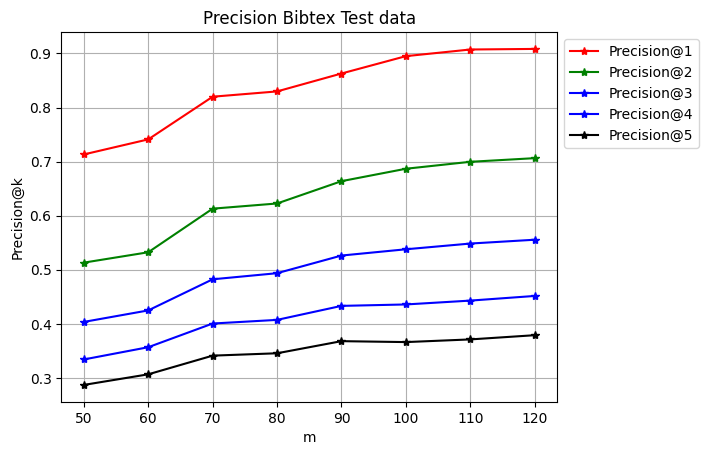

In [25]:
plt.plot(n_groups_m, p_k[:,0], 'r*-', label='Precision@1')
plt.plot(n_groups_m, p_k[:,1], 'g*-', label='Precision@2')
plt.plot(n_groups_m, p_k[:,2], 'b*-', label='Precision@3')
plt.plot(n_groups_m, p_k[:,3], 'b*-', label='Precision@4')
plt.plot(n_groups_m, p_k[:,4], 'k*-', label='Precision@5')

plt.title('Precision Bibtex Test data')
plt.ylabel('Precision@k')
plt.xlabel('m')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

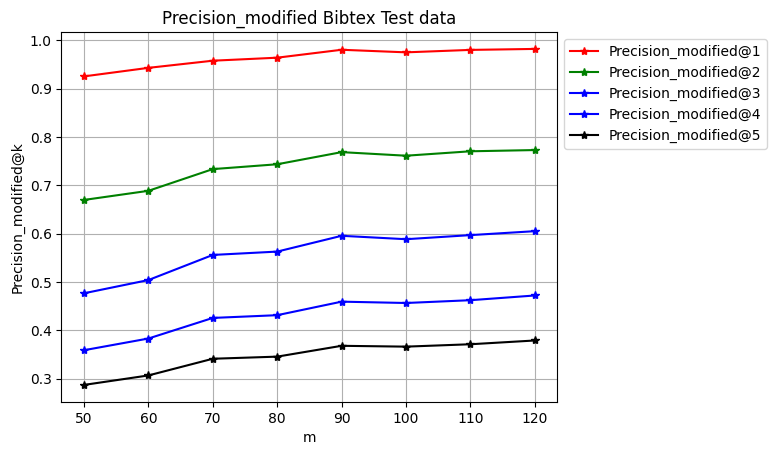

In [24]:
plt.plot(n_groups_m, pi_k[:,0], 'r*-', label='Precision_modified@1')
plt.plot(n_groups_m, pi_k[:,1], 'g*-', label='Precision_modified@2')
plt.plot(n_groups_m, pi_k[:,2], 'b*-', label='Precision_modified@3')
plt.plot(n_groups_m, pi_k[:,3], 'b*-', label='Precision_modified@4')
plt.plot(n_groups_m, pi_k[:,4], 'k*-', label='Precision_modified@5')

plt.title('Precision_modified Bibtex Test data')
plt.ylabel('Precision_modified@k')
plt.xlabel('m')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()